In [10]:
import pandas as pd
from clickhouse_driver import Client
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import swifter
import pingouin as pg

# Подключение к базе данных ClickHouse
db = 'simulator_20250420'
connection = Client(
    host='clickhouse.lab.karpov.courses',
    database=db,
    user='student',
    password='dpo_python_2020'
)

# SQL-запрос
query = f'''
SELECT exp_group, 
    user_id, 
    sum(action='like') as likes,
    sum(action='view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE exp_group in (1,2)
GROUP BY exp_group, user_id
'''

# Получение данных и автоматическое извлечение заголовков
data, columns_with_types = connection.execute(query, with_column_types=True)
column_names = [col[0] for col in columns_with_types]
main_df = pd.DataFrame(data, columns=column_names)

# Просмотр первых строк таблицы
main_df


,exp_group,user_id,likes,views,ctr
0,1,165830,48,271,0.177122
1,1,133710,56,284,0.197183
2,2,140313,56,304,0.184211
3,2,152068,99,567,0.174603
4,2,131951,197,871,0.226177
...,...,...,...,...,...
63778,2,107746,142,655,0.216794
63779,1,63551,43,224,0.191964
63780,2,81605,74,203,0.364532
63781,1,13171,66,311,0.212219


In [12]:
main_df.groupby('exp_group')['user_id'].nunique().reset_index()

,exp_group,user_id
0,1,31928
1,2,31855


<Axes: xlabel='ctr', ylabel='Count'>

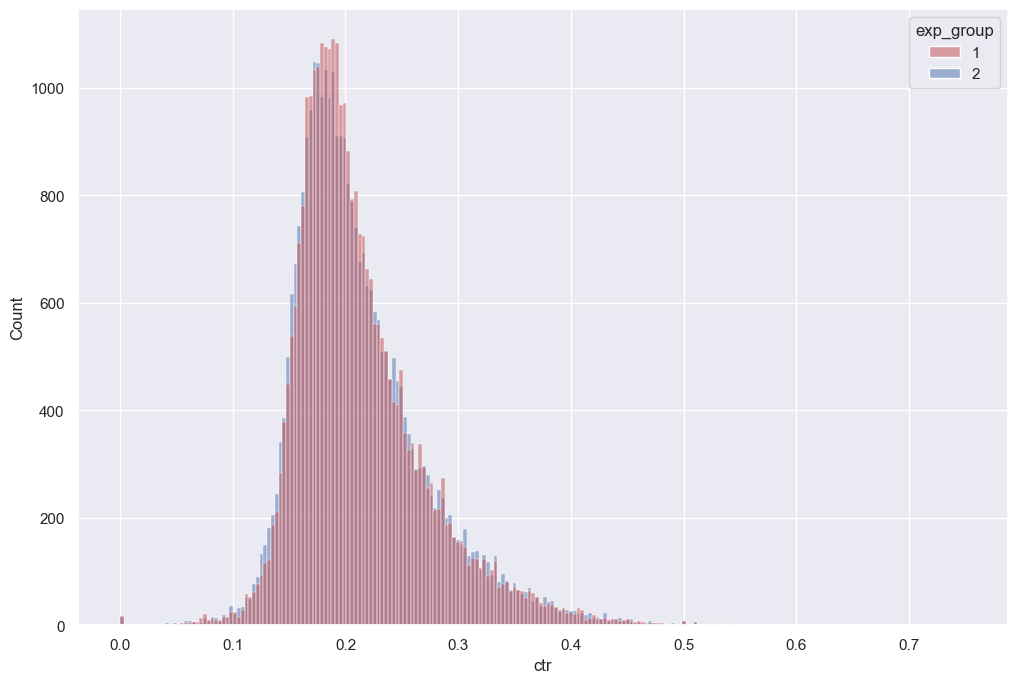

In [15]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=main_df, x='ctr', hue='exp_group', palette=['r','b'], alpha=0.5, kde=False)

In [34]:
print(f'exp_group 1 p-value: {stats.shapiro(main_df[main_df['exp_group'] == 1].ctr).pvalue}')
print(f'exp_group 1 p-value: {stats.shapiro(main_df[main_df['exp_group'] == 2].ctr).pvalue}')

exp_group 1 p-value: 2.7173412979039444e-82
exp_group 1 p-value: 3.6340779252935765e-81


E:\users\shatrov_eo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 31855.
  res = hypotest_fun_out(*samples, **kwds)


In [35]:
print(f'exp_group 1 p-value: {stats.normaltest(main_df[main_df['exp_group'] == 1].ctr).pvalue}')
print(f'exp_group 1 p-value: {stats.normaltest(main_df[main_df['exp_group'] == 2].ctr).pvalue}')

exp_group 1 p-value: 0.0
exp_group 1 p-value: 0.0


In [21]:
#Проверим нормальность
pg.normality(data=main_df, dv='ctr', group='exp_group', method='normaltest')

,W,pval,normal
exp_group,,,
1,7417.671001,0.0,False
2,7434.561124,0.0,False


((array([-4.08849056, -3.87783032, -3.76278387, ...,  3.76278387,
          3.87783032,  4.08849056]),
  array([0.        , 0.        , 0.        , ..., 0.58823529, 0.61538462,
         0.66666667])),
 (np.float64(0.055376753279046856),
  np.float64(0.21260316914826147),
  np.float64(0.9582097008376348)))

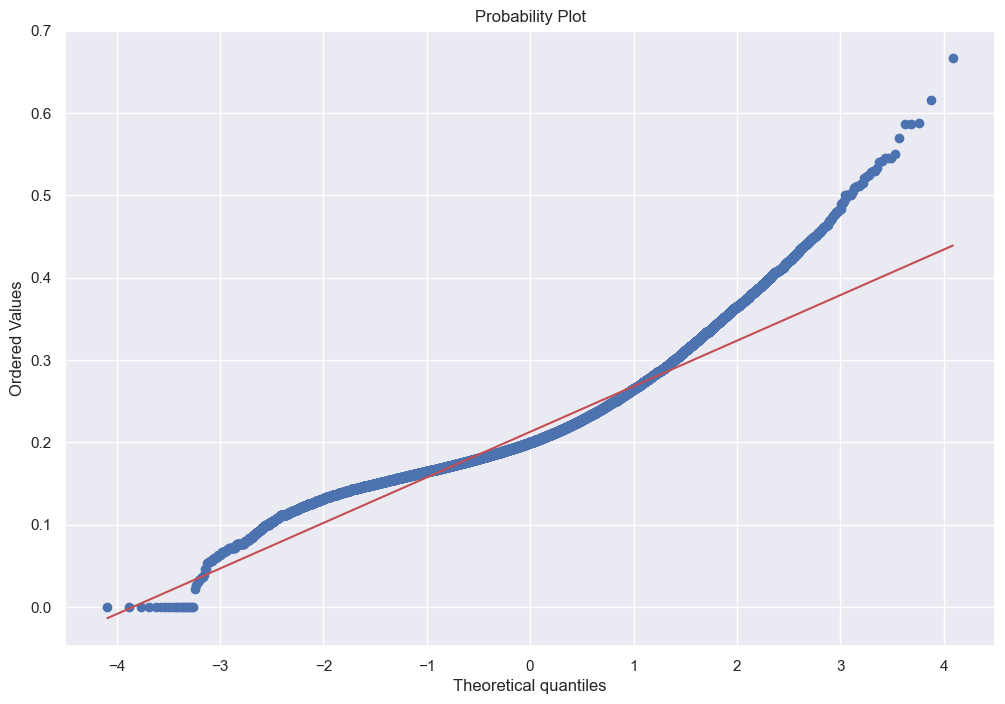

In [39]:
stats.probplot(main_df[main_df['exp_group'] == 1].ctr, dist='norm', plot=plt)

((array([-4.08795945, -3.87727325, -3.76221159, ...,  3.76221159,
          3.87727325,  4.08795945]),
  array([0.        , 0.        , 0.        , ..., 0.64705882, 0.72727273,
         0.75      ])),
 (np.float64(0.05727835333200848),
  np.float64(0.21283250436923568),
  np.float64(0.9601590198967055)))

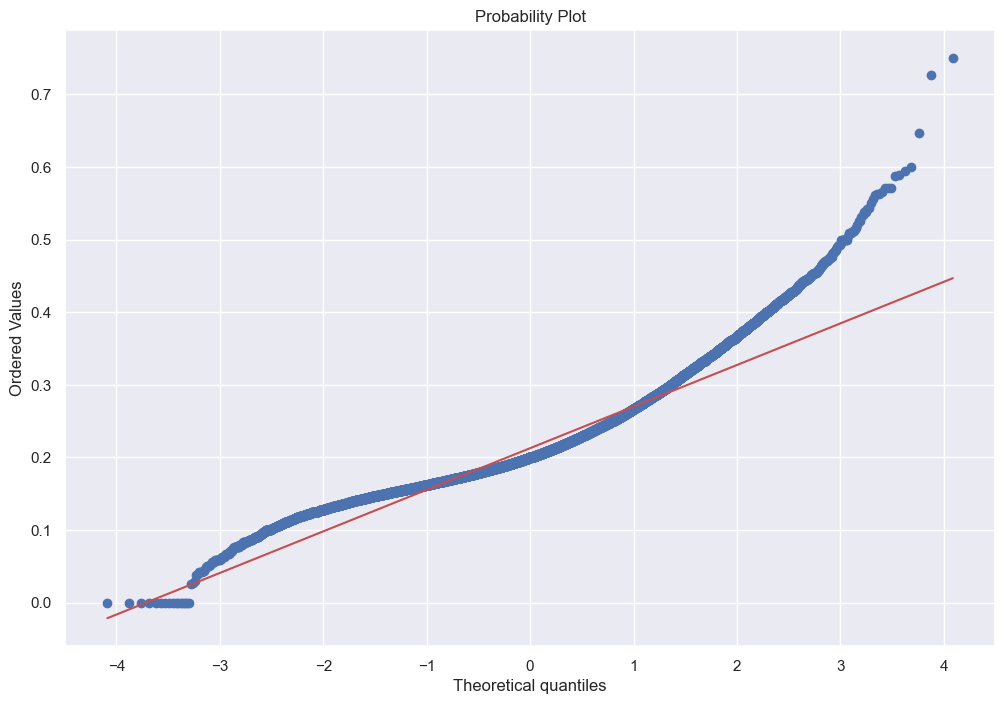

In [40]:
stats.probplot(main_df[main_df['exp_group'] == 2].ctr, dist='norm', plot=plt)

<Axes: xlabel='exp_group', ylabel='ctr'>

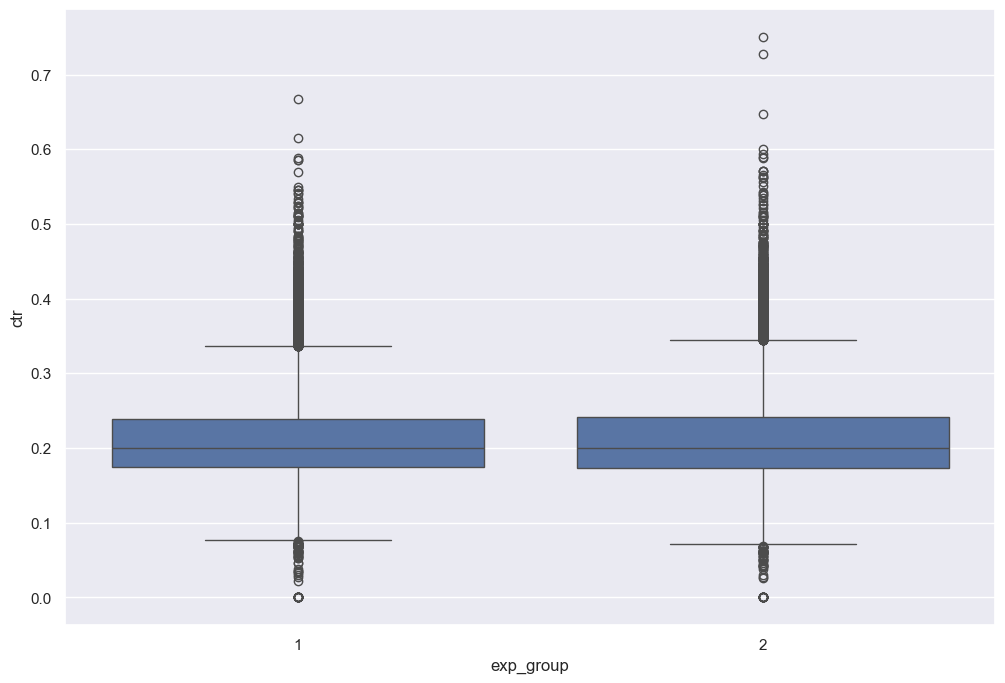

In [42]:
sns.boxplot(data=main_df, x='exp_group', y='ctr')

In [43]:
stats.ttest_ind(main_df[main_df['exp_group'] == 1].ctr,
               main_df[main_df['exp_group'] == 2].ctr,
               equal_var=False)

TtestResult(statistic=np.float64(-0.49313527669541185), pvalue=np.float64(0.6219187061812964), df=np.float64(63707.32130711429))

In [44]:
stats.mannwhitneyu(main_df[main_df['exp_group'] == 1].ctr,
                  main_df[main_df['exp_group'] == 2].ctr,
                  alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(510841756.0), pvalue=np.float64(0.32076827887444015))

<Axes: ylabel='Count'>

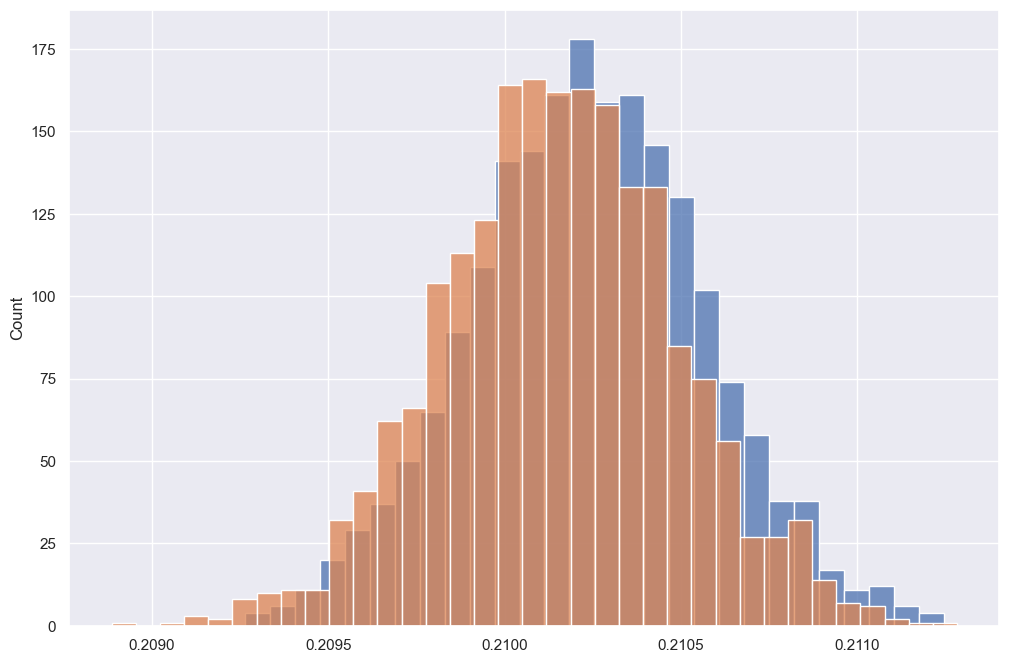

In [45]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstrap2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstrap1 * likes1).sum(axis=1) / (poisson_bootstrap1 * views1).sum(axis=1)
    globalCTR2 = (poisson_bootstrap2 * likes2).sum(axis=1) / (poisson_bootstrap2 * views2).sum(axis=1)
    
    return globalCTR1, globalCTR2


likes1 = main_df[main_df.exp_group == 1].likes.to_numpy()
views1 = main_df[main_df.exp_group == 1].views.to_numpy()
likes2 = main_df[main_df.exp_group == 2].likes.to_numpy()
views2 = main_df[main_df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

Text(0.5, 1.0, 'Гистограмма разницы между глобальными CTR')

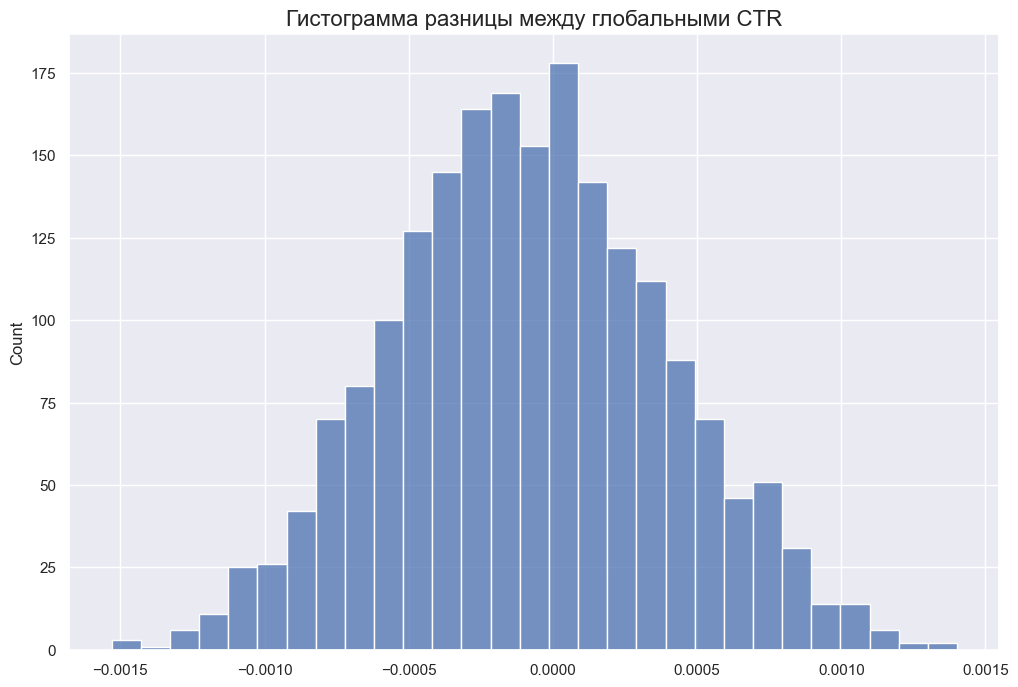

In [46]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)
plt.title('Гистограмма разницы между глобальными CTR', fontsize=16)

In [50]:
import numpy as np

group1 = main_df[main_df['exp_group'] == 1]['ctr'].values
group2 = main_df[main_df['exp_group'] == 2]['ctr'].values

boot_diff = []
n_boot = 100000

for _ in range(n_boot):
    sample1 = np.random.choice(group1, size=len(group1), replace=True)
    sample2 = np.random.choice(group2, size=len(group2), replace=True)
    boot_diff.append(np.mean(sample1) - np.mean(sample2))

boot_diff = np.array(boot_diff)
ci_lower = np.percentile(boot_diff, 2.5)
ci_upper = np.percentile(boot_diff, 97.5)
observed_diff = np.median(group1) - np.median(group2)

print(f"Observed difference in medians: {observed_diff:.4f}")
print(f"95% bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
if ci_lower > 0 or ci_upper < 0:
    print("Разница статистически значима.")
else:
    print("Разница статистически не значима.")


Observed difference in medians: -0.0003
95% bootstrap CI: [-0.0011, 0.0007]
Разница статистически не значима.
